In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import skimage.io as io
import json

In [9]:
def get_world_rot_matrx(scale, rot_x, rot_y, rot_z, trans_matrix):
    roll = math.radians(rot_x)
    pitch = math.radians(rot_y)
    yaw = math.radians(rot_z)

    rotation_x = np.array(
        [
            [1, 0, 0],
            [0, math.cos(roll), -math.sin(roll)],
            [0, math.sin(roll), math.cos(roll)],
        ]
    )

    rotation_y = np.array(
        [
            [math.cos(pitch), 0, math.sin(pitch)],
            [0, 1, 0],
            [-math.sin(pitch), 0, math.cos(pitch)],
        ]
    )

    rotation_z = np.array(
        [
            [math.cos(yaw), -math.sin(yaw), 0],
            [math.sin(yaw), math.cos(yaw), 0],
            [0, 0, 1],
        ]
    )

    rotation_matrix = np.dot(np.dot(rotation_z, rotation_y), rotation_x)
    rotation_matrix *= scale

    I = np.eye(4)
    I[:3, :3] = rotation_matrix
    I[:3, 3] = trans_matrix

    RT = I

    return RT

In [10]:
# Camera related settings based on blender default transform setting

world_RT = [
    [0.0010000000474974513, 0.0, 0.0, 0.0],
    [0.0, -4.371138867531599e-11, 0.0010000000474974513, 0.0],
    [0.0, -0.0010000000474974513, -4.371138867531599e-11, 0.0],
    [0.0, 0.0, 0.0, 1.0],
]

# Intrinsic camera matrix. fx/fy and cx/cy should be consistent with your rendering settings
K = np.array([[355.0, 0.0, 112.0], [0.0, 355.0, 112.0], [0.0, 0.0, 1]])

In [11]:
# Project 3D coordinates into image space
def projectPoints(xyz, K):
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T

    return uv[:, :2] / uv[:, -1:]

In [12]:
def plot_hand(
    axis, coords_hw, vis=None, color_fixed=None, linewidth="1", order="hw", draw_kp=True
):
    if order == "uv":
        coords_hw = coords_hw[:, ::-1]

    colors = np.array(
        [
            [0.4, 0.4, 0.4],
            [0.4, 0.0, 0.0],
            [0.6, 0.0, 0.0],
            [0.8, 0.0, 0.0],
            [1.0, 0.0, 0.0],
            [0.4, 0.4, 0.0],
            [0.6, 0.6, 0.0],
            [0.8, 0.8, 0.0],
            [1.0, 1.0, 0.0],
            [0.0, 0.4, 0.2],
            [0.0, 0.6, 0.3],
            [0.0, 0.8, 0.4],
            [0.0, 1.0, 0.5],
            [0.0, 0.2, 0.4],
            [0.0, 0.3, 0.6],
            [0.0, 0.4, 0.8],
            [0.0, 0.5, 1.0],
            [0.4, 0.0, 0.4],
            [0.6, 0.0, 0.6],
            [0.7, 0.0, 0.8],
            [1.0, 0.0, 1.0],
        ]
    )

    colors = colors[:, ::-1]

    # define connections and colors of the bones
    bones = [
        ((0, 1), colors[1, :]),
        ((1, 2), colors[2, :]),
        ((2, 3), colors[3, :]),
        ((3, 4), colors[4, :]),
        ((0, 5), colors[5, :]),
        ((5, 6), colors[6, :]),
        ((6, 7), colors[7, :]),
        ((7, 8), colors[8, :]),
        ((0, 9), colors[9, :]),
        ((9, 10), colors[10, :]),
        ((10, 11), colors[11, :]),
        ((11, 12), colors[12, :]),
        ((0, 13), colors[13, :]),
        ((13, 14), colors[14, :]),
        ((14, 15), colors[15, :]),
        ((15, 16), colors[16, :]),
        ((0, 17), colors[17, :]),
        ((17, 18), colors[18, :]),
        ((18, 19), colors[19, :]),
        ((19, 20), colors[20, :]),
    ]

    if vis is None:
        vis = np.ones_like(coords_hw[:, 0]) == 1.0

    for connection, color in bones:
        if (vis[connection[0]] == False) or (vis[connection[1]] == False):
            continue

        coord1 = coords_hw[connection[0], :]
        coord2 = coords_hw[connection[1], :]
        coords = np.stack([coord1, coord2])
        if color_fixed is None:
            axis.plot(coords[:, 1], coords[:, 0], color=color, linewidth=linewidth)
        else:
            axis.plot(coords[:, 1], coords[:, 0], color_fixed, linewidth=linewidth)

    if not draw_kp:
        return

    for i in range(21):
        if vis[i] > 0.5:
            axis.plot(coords_hw[i, 1], coords_hw[i, 0], "o", color=colors[i, :])

In [13]:
def apply_RT(coords, cam_RT):
    homo_coords = np.hstack((coords, np.ones((coords.shape[0], 1))))

    trans_coords = np.dot(world_RT, homo_coords.T).T
    trans_coords = np.dot(cam_RT, trans_coords.T).T[:, :3]

    return trans_coords

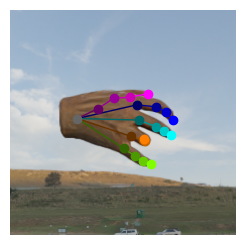

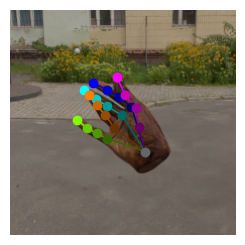

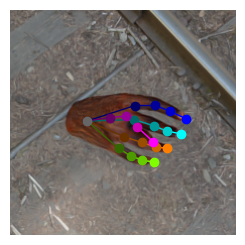

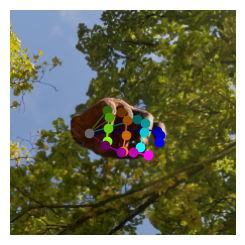

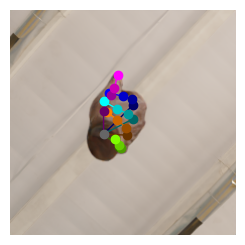

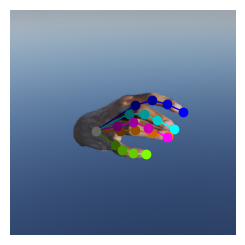

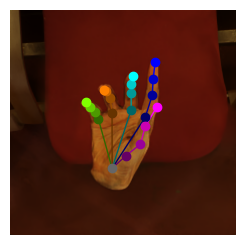

In [14]:
# View combined data samples (joints and verts are already transformed to camera coordinate system)
img_path = "../images"

samples = sorted(os.listdir("../samples"))
joints_list = []

for sample in samples:
    json_path = os.path.join("../samples", sample, "joints.json")
    with open(json_path, "r") as json_file:
        joints_list.append(json.load(json_file))

cam_RT = [
    [1.0, 0.0, 0.0, 0.0],
    [0.0, -1.0, 0.0, 0.0],
    [0.0, 0.0, -1.0, 0.5],
    [0.0, 0.0, 0.0, 1.0],
]

# Or read from the exported cam_RT_syn_data_X.json if different cam RT are used for rendering
# with open("../cam_RT_syn_data_0.json", "r") as json_file:
#     cam_RT = json.load(json_file)

length = 8
is_plot_hand = True

for idx, joints in enumerate(joints_list, start=0):
    joints = joints_list[idx]

    joints = apply_RT(np.array(joints), cam_RT)
    uv = projectPoints(joints, K)

    id = str(idx).rjust(length, "0")
    img = io.imread(os.path.join(img_path, "rgb_1", id + ".png"))

    # show
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.imshow(img)

    if is_plot_hand:
        plot_hand(ax1, uv, order="uv")
    ax1.axis("off")
    plt.show()